# 0.0. Introducao

## 0.1. Bibliotecas

In [110]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from tabulate import tabulate
from scipy import stats

from IPython.core.display import HTML
from IPython.display import Image
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 0.2. Funções Auxiliares

In [ ]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k - 1) * (r - 1) / (n-1) )
    
    kcorr = k - ( k - 1 ) ** 2 / ( n - 1 )
    rcorr = r - ( r - 1 ) ** 2 / ( n - 1 )
    
    return np.sqrt( (chi2corr / n) / (min( kcorr-1, rcorr-1 ) ) )

## 0.3. Carregar os Dados

In [2]:
df_sales_raw = pd.read_csv( 'train.csv', low_memory= False )
df_store_raw = pd.read_csv( 'store.csv', low_memory= False )


# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how = 'left', on = 'Store' )

# 1.0. Descrição dos Dados

In [3]:
df1 = df_raw.copy()

## 1.1. Renomear Colunas

In [4]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

new_cols = list( map( snakecase, old_cols ))

df1.columns = new_cols

## 1.2. Dimensões dos Dados

In [5]:
print( 'Numero de Linhas:  {}'.format( df1.shape[0] ) )
print( 'Numero de Colunas: {}'.format( df1.shape[1] ) )

Numero de Linhas:  1017209
Numero de Colunas: 18


## 1.3. Tipos de Dados

In [6]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [7]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [8]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 20000.0 if math.isnan( x ) else x )

# competition_open_since_month 
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1 )

# competition_open_since_year  
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1 )
                      
# promo2_since_week            
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1 )

# promo2_since_year            
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1 )

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Out', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1 )

## 1.6. Dundança de Tipos

In [9]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

## 1.7. Estatítisca Descritiva

In [10]:
num_atributos = df1.select_dtypes( include = ['int64', 'float64'] )
cat_atributos = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Atributos Numéricos

In [11]:
# tendencia central - mean, median
tc1 = pd.DataFrame( num_atributos.apply( np.mean ) ).T
tc2 = pd.DataFrame( num_atributos.apply( np.median ) ).T

# dispersao - max, min, std, range, skew, kurtosis
d1 = pd.DataFrame( num_atributos.apply( max ) ).T
d2 = pd.DataFrame( num_atributos.apply( min ) ).T
d3 = pd.DataFrame( num_atributos.apply( np.std ) ).T
d4 = pd.DataFrame( num_atributos.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_atributos.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_atributos.apply( lambda x: x.kurtosis() ) ).T

#concat
m = pd.concat( [d2, d1, d4, tc1, tc2, d3, d5, d6] ).T.reset_index()
m.columns = ['Atributos', 'Min', 'Max', 'Range', 'Media', 'Mediana', 'STD', 'Skew', 'Kurtosis']

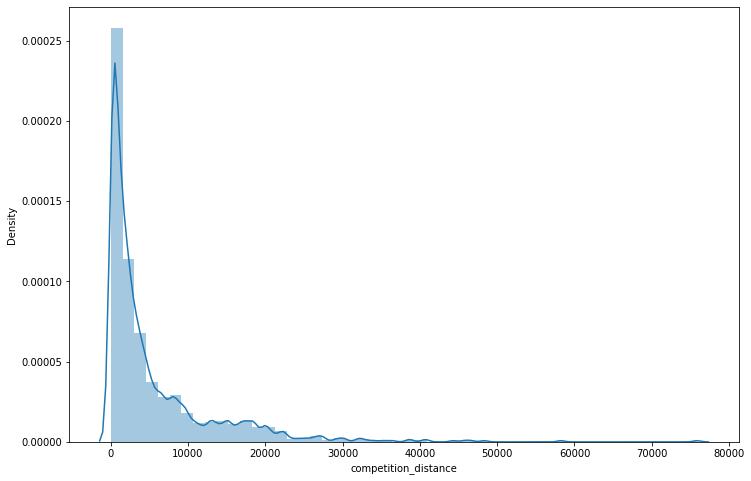

In [12]:
plt.figure( figsize=( 12,8 ) )
sns.distplot( df1['competition_distance'] );

### 1.7.2 Atributos Numéricos

In [13]:
cat_atributos.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

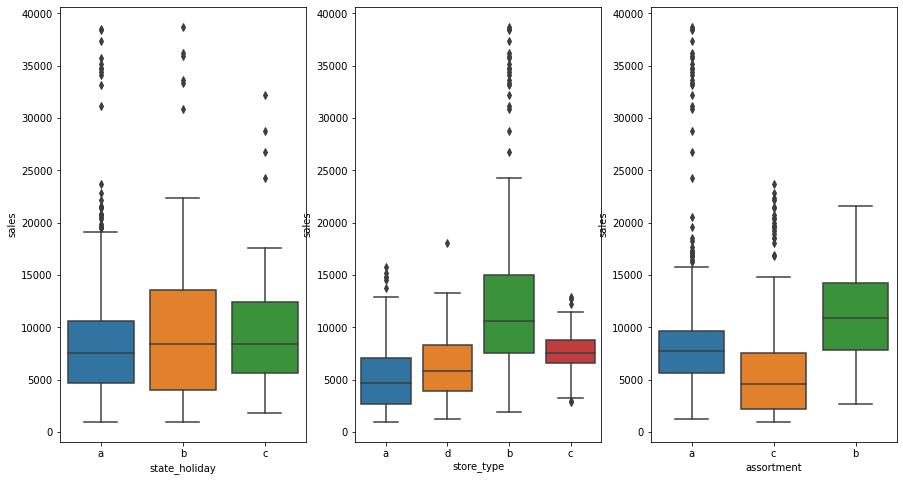

In [14]:
aux1 = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 ) ]

plt.figure( figsize=( 15,8 ) )

plt.subplot( 1, 3, 1 )
sns.boxplot( x= 'state_holiday', y='sales' , data=aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x= 'store_type', y='sales', data= aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x= 'assortment', y = 'sales', data= aux1 );

# 2.0. Feature Engeneering

## 2.1. Mapa Mental de Hipoteses

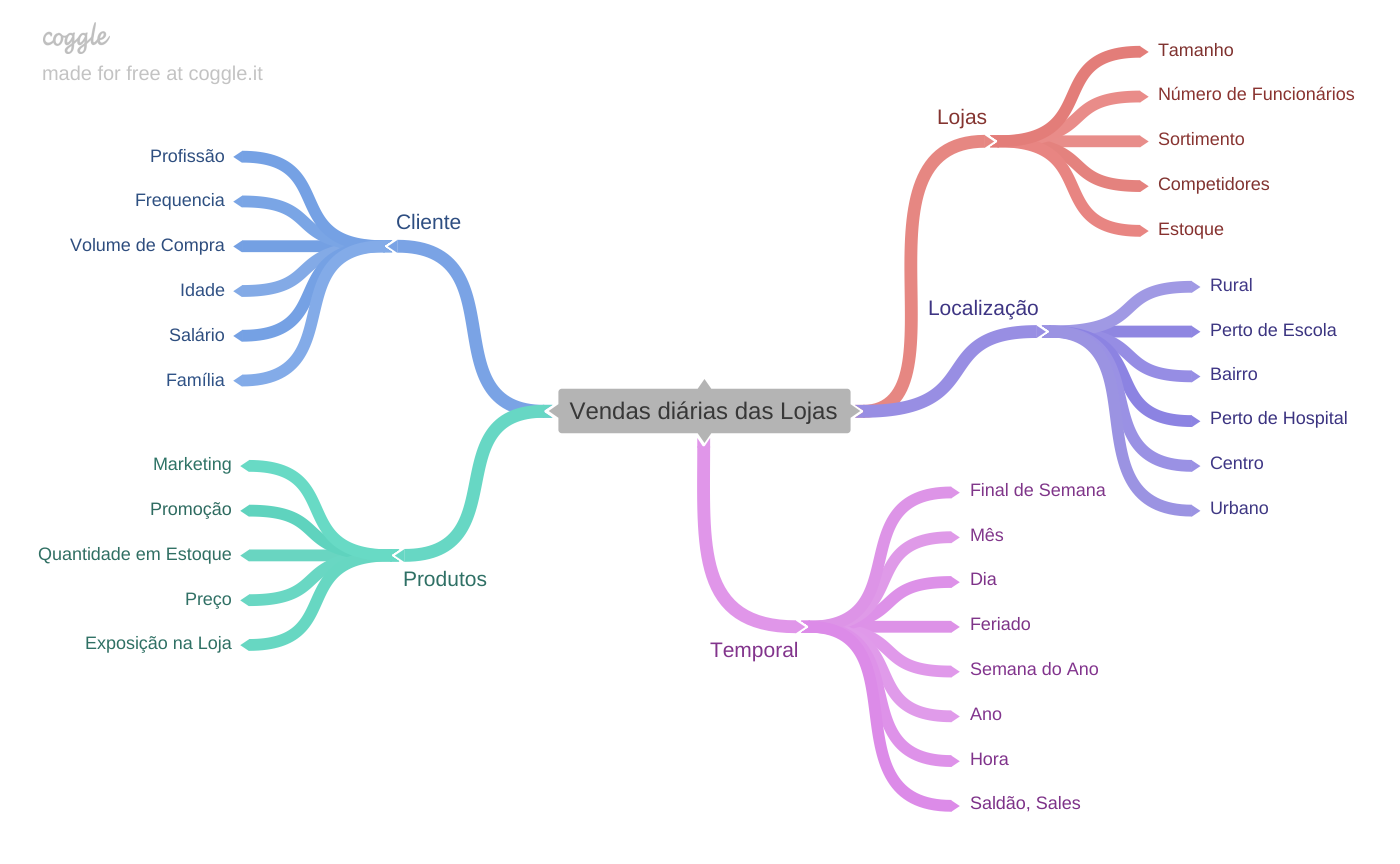

In [15]:
Image( 'Vendas_diarias_das_Lojas.coogle.png' )

## 2.2. Cricao das Hipoteses

In [16]:
df2 = df1.copy()

### 2.2.1 Hipoteses Loja

- Lojas com número maior de funcionários deveriam vender mais.
- Lojas com maior capaciadade de estoque deveriam vender mais.
- Lojas com maior porte deveriam vender mais.
- Lojas com maior sortimento de produtos deveriam vender mais.
- Lojas com competidores mais próximos deveriam vender menos.
- Lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2 Hipoteses Produto

- Lojas que investem mais em marketing deveriam vender mais.
- Lojas com maior exposição de produtos deveriam vender mais.
- Lojas com produtos com preço menor deveriam vender mais.
- Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
- Lojas com promoções ativas por mais tempo deveriam vender mais.
- Lojas com mais dias de promoção deveriam vender mais.
- Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipoteses Tempo

- Lojas abertas durante o feriado de Natal deveriam vender mais.
- Lojas deveriam vender mais ao longo dos anos.
- Lojas deveriam vender mais durante o segundo semestre do ano.
- Lojas deveriam vender mais depois do dia 10 de cada mês.
- Lojas deveriam vender menos durante os finais de semana.
- Lojas deveriam vender menos durante os feriados escolares.

### 2.2.4 Lista final de Hipoteses

**1.** Lojas com maior sortimento de produtos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais durante o segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos durante os finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engeneering

In [17]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime( year = x['competition_open_since_year'] , month = x['competition_open_since_month'], day = 1  ), axis = 1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( 'int64' ) 

# promo since 
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days = 7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( 'int64' )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else
                                                       'extra' if x == 'b' else
                                                       'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else
                                                             'easter_holiday' if x == 'b' else
                                                             'christmas' if x == 'c' else
                                                             'regular_day' )

# 3.0. Filtragem de Variáveis

In [18]:
df3 = df2.copy()

In [19]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [20]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2. Filtragem das Colunas

In [21]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis = 1 )

# 4.0. Analise Exploratoria dos Dados

In [22]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Variavel Resposta

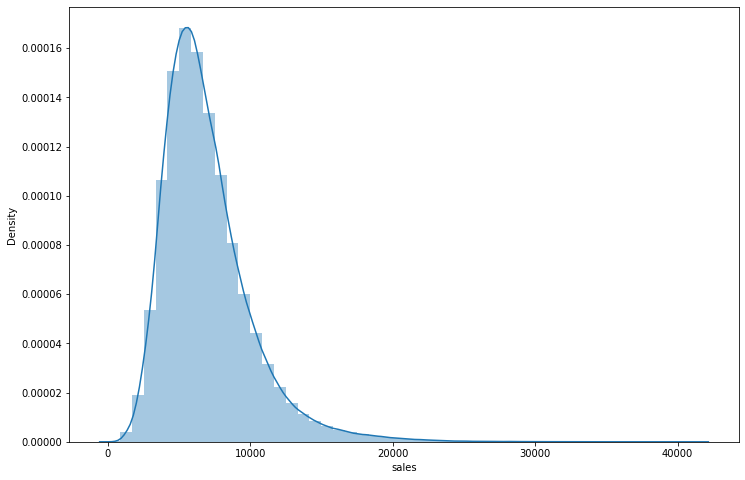

In [23]:
plt.figure( figsize = ( 12,8 ) ) 
sns.distplot( df4['sales']);

### 4.1.2. Variavel Numerica

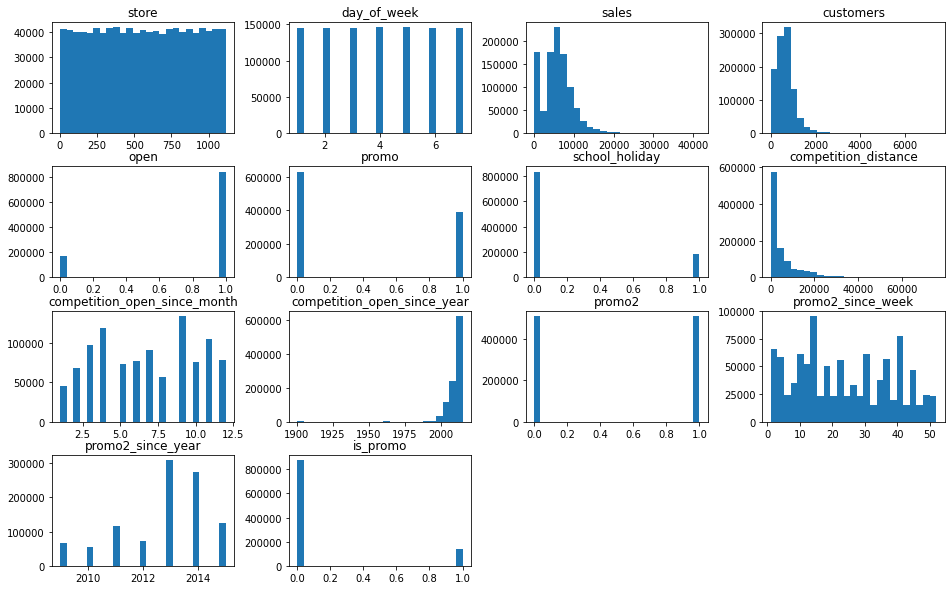

In [24]:
num_atributos.hist(grid = False, figsize = ( 16,10 ), bins = 25 );

Com esses plots podemos tirar algumas conclusões:
- A variável resposta é bem próxima de uma distribuição normal
- A maior frequencia de vendas se concentra entre 400 e 800
- A maior parte dos competidores se concentram próximos das lojas da Rossmann
- A maior parte das promoções são feitas nas primeiras 15 semanas do ano
- A empresa fez muitas promoções em 2013 e 2014, em 2015 as promoções voltaram para patar próximo aos de 2011

### 4.1.3. Variavel Categorica

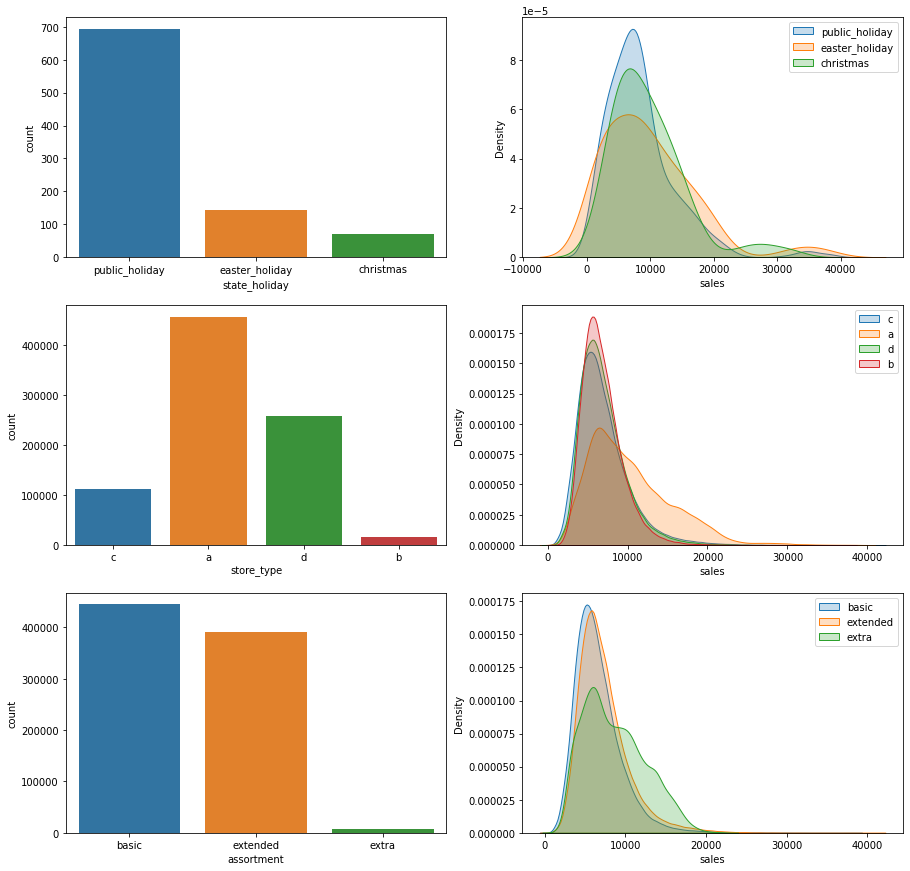

In [52]:
# state_holiday
plt.figure( figsize = (15,15) )
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], shade = True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade = True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], shade = True )
plt.legend( labels = ['public_holiday', 'easter_holiday', 'christmas'] );

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], shade = True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], shade = True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], shade = True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], shade = True )
plt.legend( labels = ['c', 'a', 'd', 'b' ] );

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], shade = True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], shade = True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], shade = True )
plt.legend( labels = ['basic', 'extended', 'extra'] );

## 4.2. Analise Bivariada

### 4.2.1. H1) Lojas com maior sortimento de produtos deveriam vender mais.
 **Falsa**. Lojas com maior sortimento vendem MENOS.

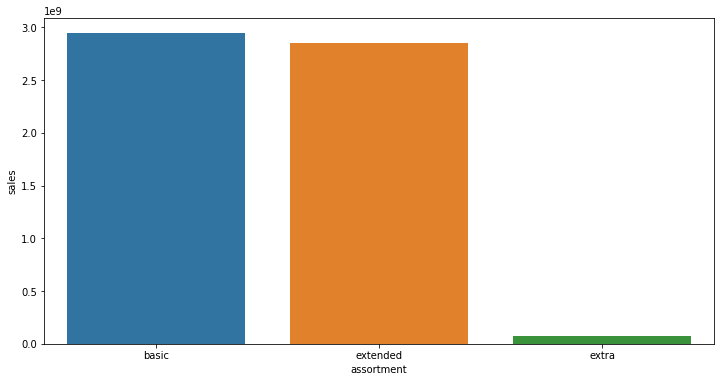

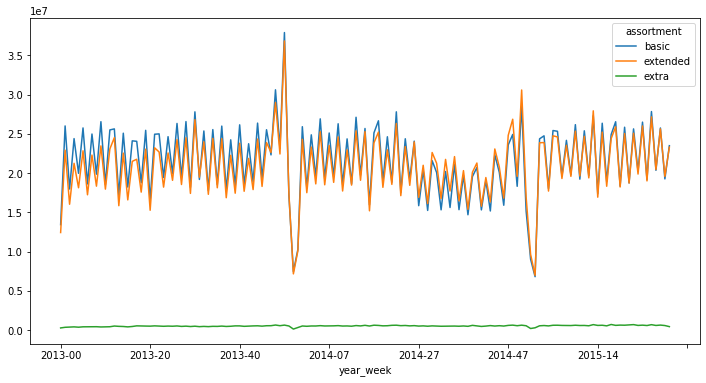

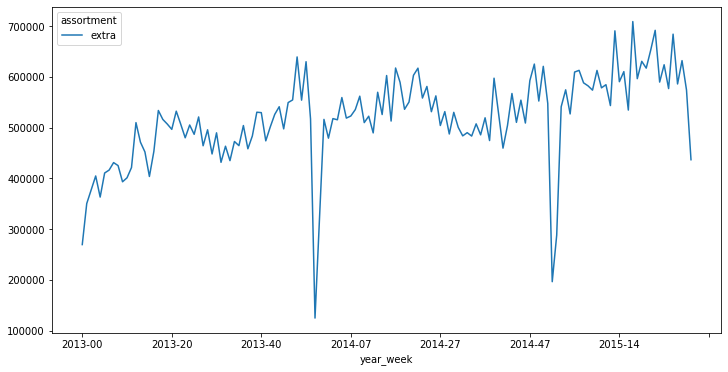

In [72]:
aux1 = df4[['sales', 'assortment']].groupby( 'assortment' ).sum().reset_index().sort_values( 'sales', ascending = False )
aux2 = df4[[ 'year_week', 'sales', 'assortment']].groupby( ['year_week' ,'assortment'] ).sum().reset_index().sort_values( 'sales', ascending = False )
aux3 = aux2[aux2['assortment'] == 'extra']

plt.figure( figsize = ( 12,6 ) )
sns.barplot( x= 'assortment', y = 'sales', data = aux1 );

aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales' ).plot( figsize = ( 12,6 ) );

aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales' ).plot( figsize = ( 12,6 ) );

### 4.2.2. H2) Lojas com competidores mais próximos deveriam vender menos.
**Falsa.** Quanto maior a distancia dos competidores MENOR a venda.

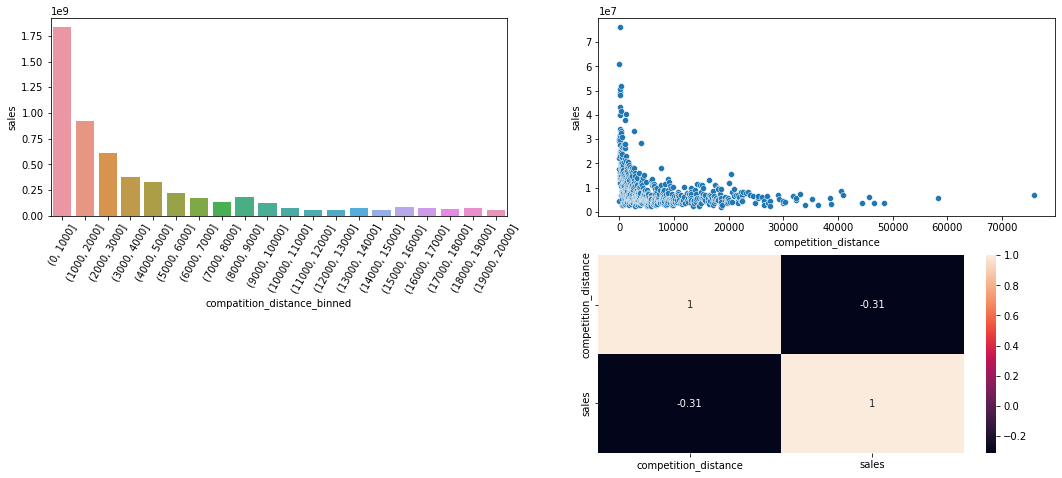

In [48]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

bins = ( np.arange( 0, 21000, 1000 ) )

aux1['compatition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins )
aux2 = aux1[['compatition_distance_binned', 'sales']].groupby( 'compatition_distance_binned' ).sum().reset_index()

plt.figure( figsize = ( 18,8 ) )

plt.subplot( 2, 2, 1 )
sns.barplot( x = 'compatition_distance_binned', y = 'sales', data = aux2 )
plt.xticks( rotation = 60 );

plt.subplot( 2, 2, 2 )
sns.scatterplot( x = 'competition_distance', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 4 )
sns.heatmap( aux1.corr( method= 'pearson' ), annot= True);

### 4.2.3. H3) Lojas com competidores a mais tempo deveriam vender mais.
**Falsa.** Lojas com competidores a mais tempo vendem MENOS.

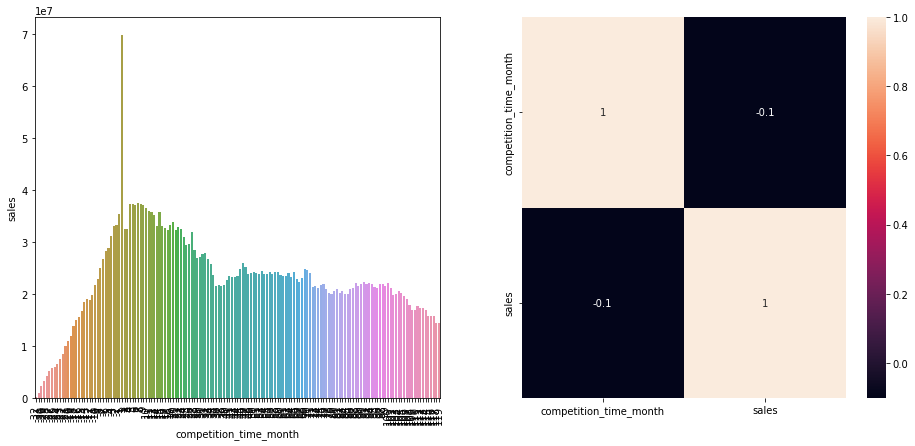

In [46]:
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[ (aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 ) ]

plt.figure( figsize = ( 16, 7 ) )

plt.subplot( 1, 2, 1 )
sns.barplot( x = 'competition_time_month', y = 'sales', data = aux2 )
plt.xticks( rotation = 90 );

plt.subplot( 1, 2, 2 )
sns.heatmap( aux1.corr(method = 'pearson'), annot= True  );

### 4.2.4. H4) Lojas com promoções ativas por mais tempo deveriam vender mais.
**Falsa.** Lojas com promoção ativa por mais tempo vendem MENOS, depois de um determinado período. 

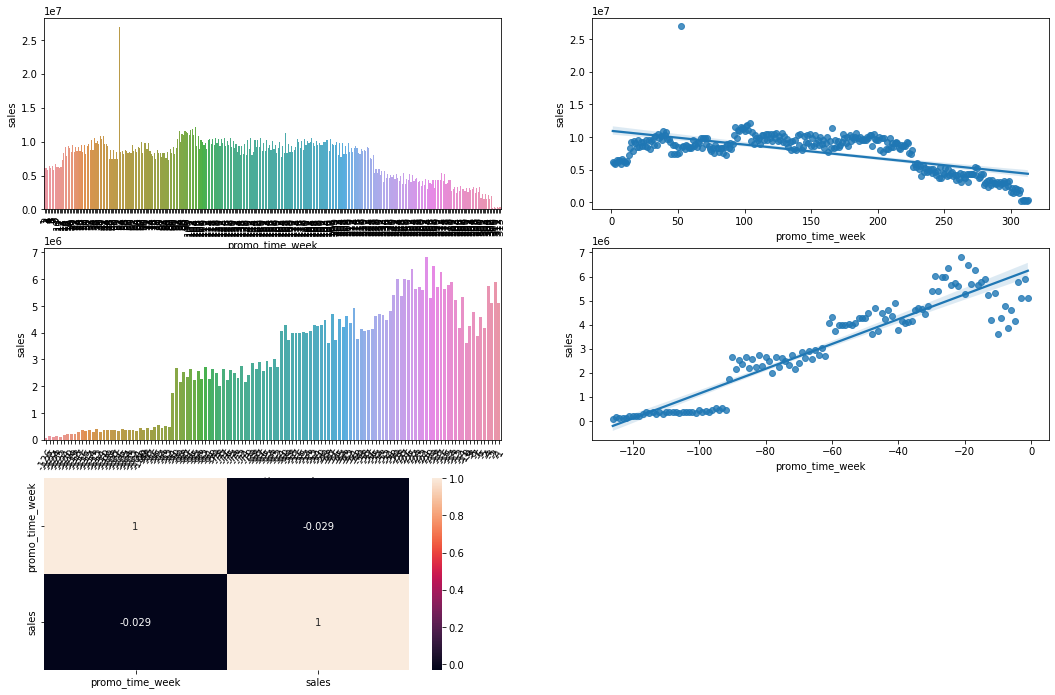

In [45]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

plt.figure( figsize = ( 18,12 ) )

plt.subplot( 3, 2, 1 )
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux2 )
plt.xticks( rotation = 90 );

plt.subplot( 3, 2, 2 )
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux2 );

plt.subplot( 3, 2, 3 )
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux3 )
plt.xticks( rotation = 60 );

plt.subplot( 3, 2, 4 )
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux3 );

plt.subplot( 3, 2, 5 )
sns.heatmap( aux1.corr( method= 'pearson'), annot= True );

### <s> 4.2.5. H5) Lojas com mais dias de promoção deveriam vender mais. </s>


### 4.2.6. H6) Lojas com mais promoções consecutivas deveriam vender mais.
**Falsa.** Lojas com mais promoções consecutivas vendem MENOS.

In [30]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


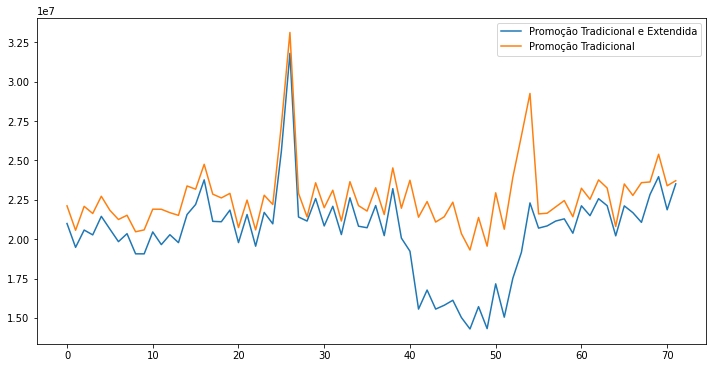

In [31]:
aux1 = df4[( df4['promo'] == 1) & (df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax = ax, figsize = ( 12,6 ) )

plt.legend( ['Promoção Tradicional e Extendida', 'Promoção Tradicional' ] );

### 4.2.7. H7) Lojas abertas durante o feriado de Natal deveriam vender mais.
**Verdadeiro.** Lojas abertas durante o feriado de Natal vendem mais, em média.

In [84]:
aux2

,state_holiday,sales
0,christmas,9743.746
1,easter_holiday,9566.146
2,public_holiday,8257.533


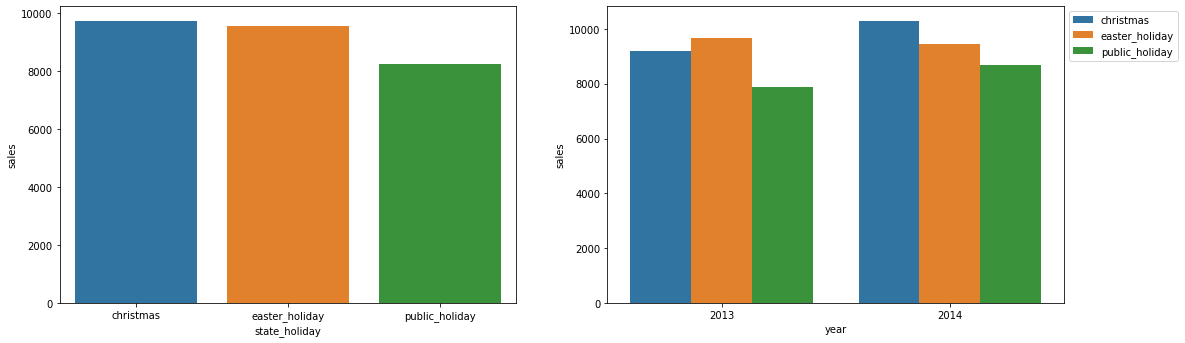

In [91]:
aux1 = df4[( df4['state_holiday'] != 'regular_day' ) & ( df4['year'] != 2015 )]
aux2 = aux1[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()

plt.figure( figsize = ( 18,12 ))
plt.subplot( 2, 2, 1 )
sns.barplot( x = 'state_holiday', y = 'sales', data = aux2 );

aux3 = aux1[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).mean().reset_index()

plt.subplot( 2, 2, 2 )
sns.barplot( x = 'year', y = 'sales', hue = 'state_holiday', data = aux3, )
plt.legend( loc='center left', bbox_to_anchor=(1, 0.9), ncol=1 );

### 4.2.8. H8) Lojas deveriam vender mais ao longo dos anos.
**Falsa** Lojas Vendem MENOS ao longo dos anos.

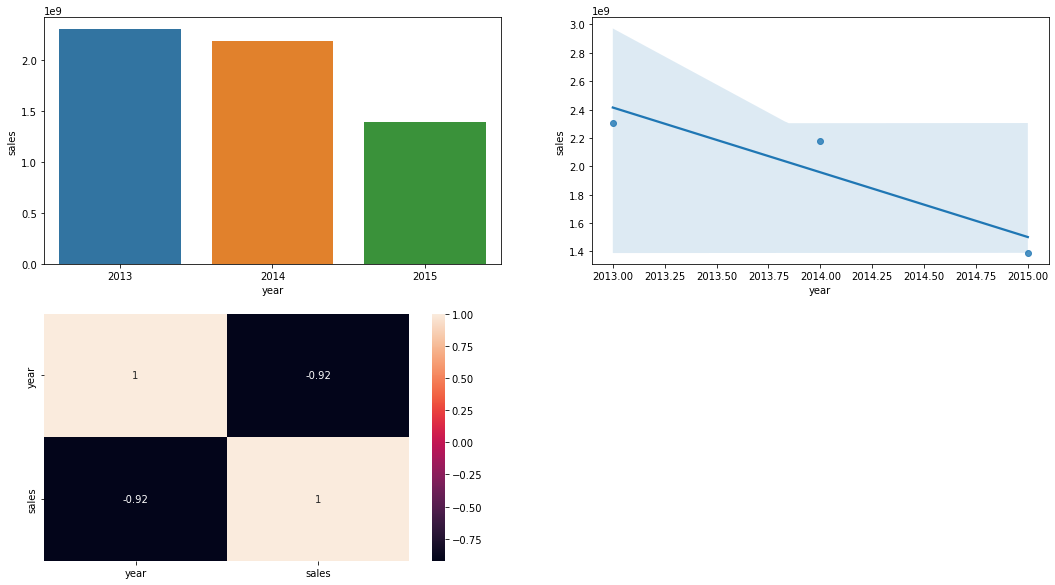

In [85]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.figure( figsize = ( 18,10 ) )

plt.subplot( 2, 2, 1 )
sns.barplot( x = 'year', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x = 'year', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

### 4.2.9. H9) Lojas deveriam vender mais durante o segundo semestre do ano.
**Verdadeiro.** Lojas vendem, em média, 4,62% a mais no segundo semestre.

In [92]:
aux = df4[df4['year'] != 2015 ]
aux1 = aux[['month', 'sales']].groupby( 'month' ).mean().reset_index()

bins = ( np.arange( 0, 13, 6 ) )
aux1['semester'] = pd.cut( aux1['month'], bins = bins )

aux1[['semester', 'sales']].groupby( 'semester' ).mean().reset_index()

,semester,sales
0,"(0, 6]",6771.293
1,"(6, 12]",7084.546


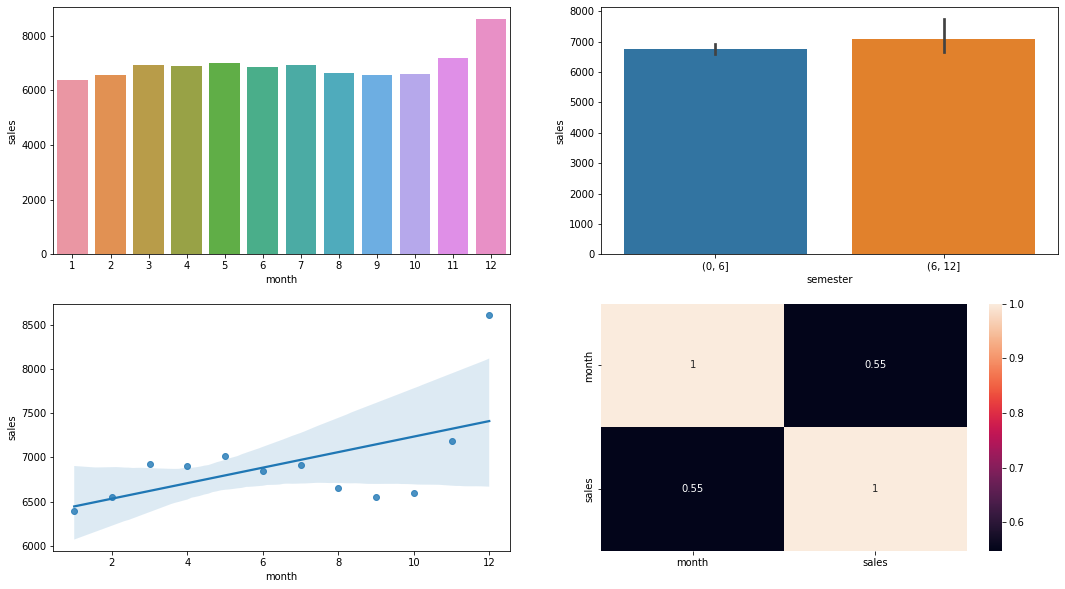

In [93]:
plt.figure( figsize = ( 18,10 ) )

plt.subplot( 2, 2, 1)
sns.barplot( x = 'month', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 2)
sns.barplot( x = 'semester', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 3)
sns.regplot( x = 'month', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 4)
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

### 4.2.10 H10) Lojas deveriam vender mais antes do dia 10 de cada mês.
**Verdadeiro.** Em média, lojas vendem 7,08% a mais antes do 10 dia de cada mês. 

In [94]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).mean().reset_index()
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )

aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).mean().reset_index()

aux2

,before_after,sales
0,after_10_days,6824.773
1,before_10_days,7307.763


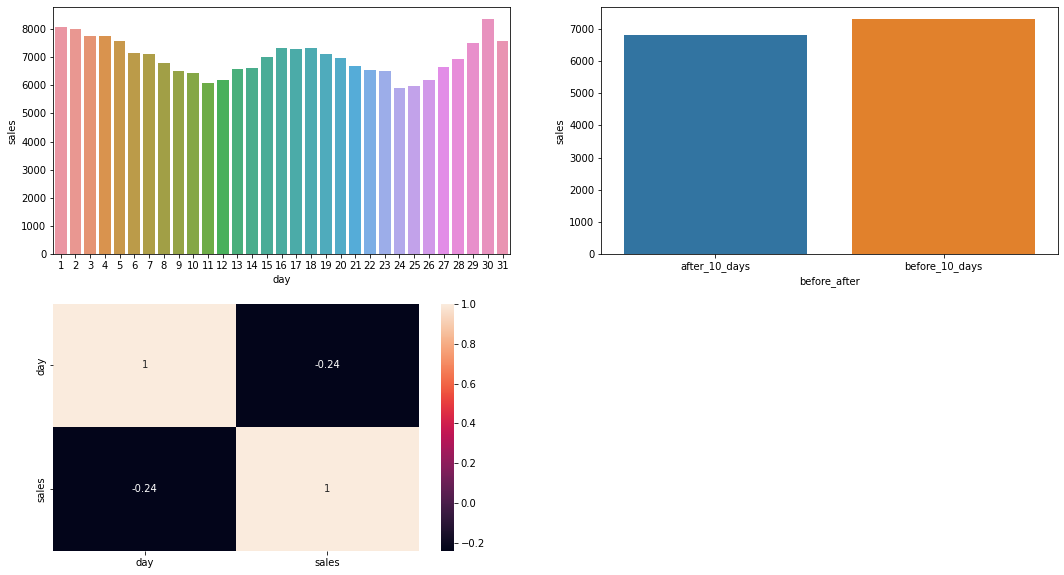

In [95]:
plt.figure( figsize = ( 18,10 ) )

plt.subplot( 2, 2, 1 )
sns.barplot( x = 'day', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 2 )
sns.barplot( x = 'before_after', y = 'sales', data = aux2 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

### 4.2.11. H11) Lojas deveriam vender menos durante os finais de semana.
**Verdadeiro.** Lojas vendem, em média, MENOS durante os finais de semana. 

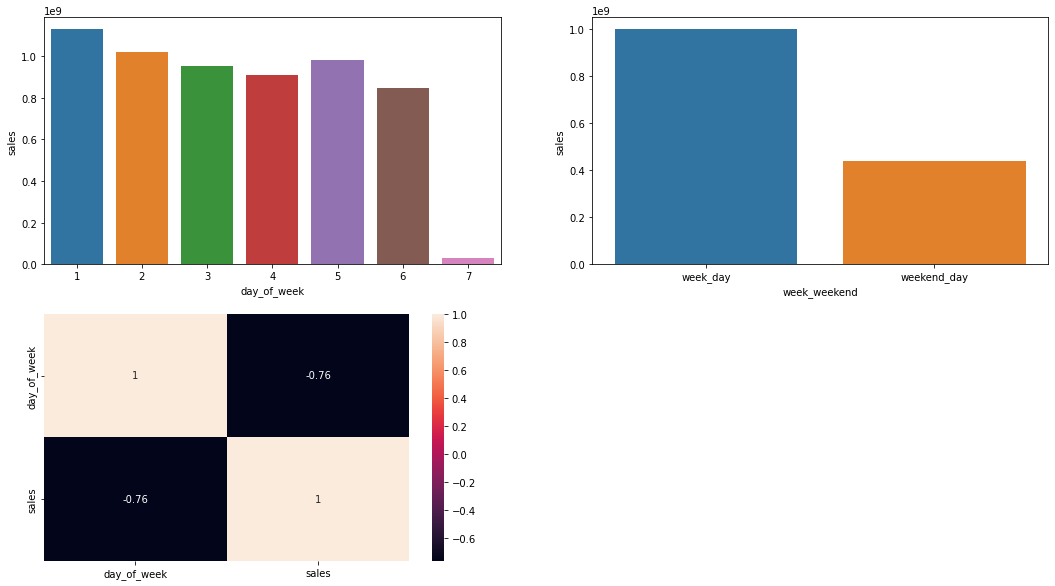

In [36]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
aux1['week_weekend'] = aux1['day_of_week'].apply( lambda x: 'week_day' if x <= 5 else 'weekend_day' )

aux2 = aux1[['week_weekend', 'sales']].groupby( 'week_weekend' ).mean().reset_index()

plt.figure( figsize = ( 18,10 ) )

plt.subplot( 2, 2, 1 )
sns.barplot( x = 'day_of_week', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 2 )
sns.barplot( x = 'week_weekend', y = 'sales', data = aux2 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

### 4.2.12. H12) Lojas deveriam vender menos nos feriados escolares
**Verdadeiro.** Lojas vendem menos nos feriados escolares, exceto no mes de Agosto.

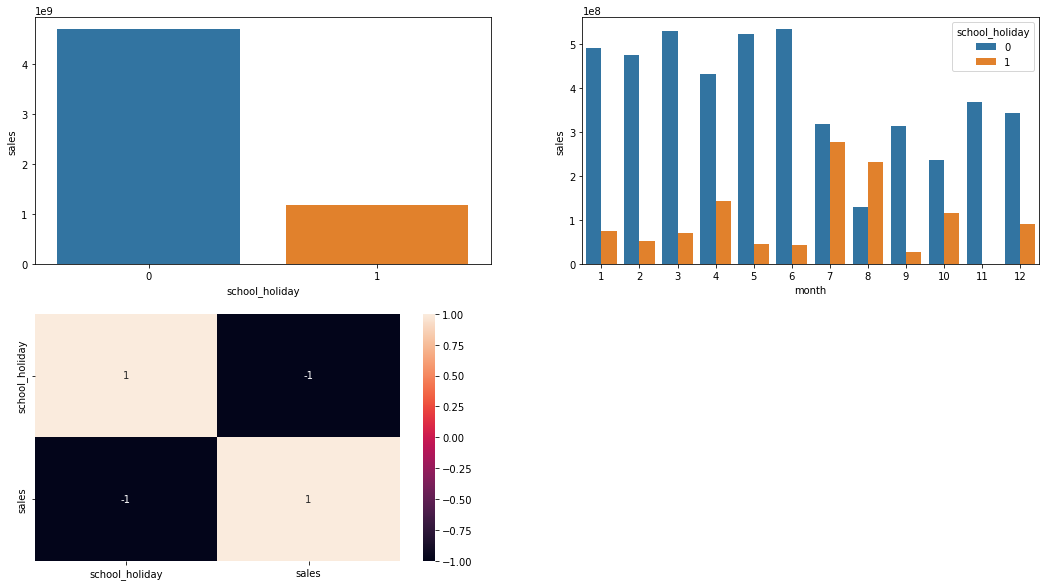

In [96]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()

plt.figure( figsize = ( 18,10 ) )

plt.subplot( 2, 2, 1 )
sns.barplot( x = 'school_holiday', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 2 )
sns.barplot( x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

### 4.2.13. Resumo das hipoteseses

In [98]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falda', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Verdadeiro', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Verdadeiro', 'Alta'],
      ['H10', 'Verdadeiro', 'Media'],
      ['H11', 'Verdadeiro', 'ALta'],
      ['H12', 'Verdadeiro', 'Alta'],
      ]
print( tabulate( tab, headers= 'firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falda        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Verdadeiro   Media
H8           Falsa        Alta
H9           Verdadeiro   Alta
H10          Verdadeiro   Media
H11          Verdadeiro   ALta
H12          Verdadeiro   Alta


## 4.3. Analise Muitivariada

### 4.3.1. Atributos Numericos 

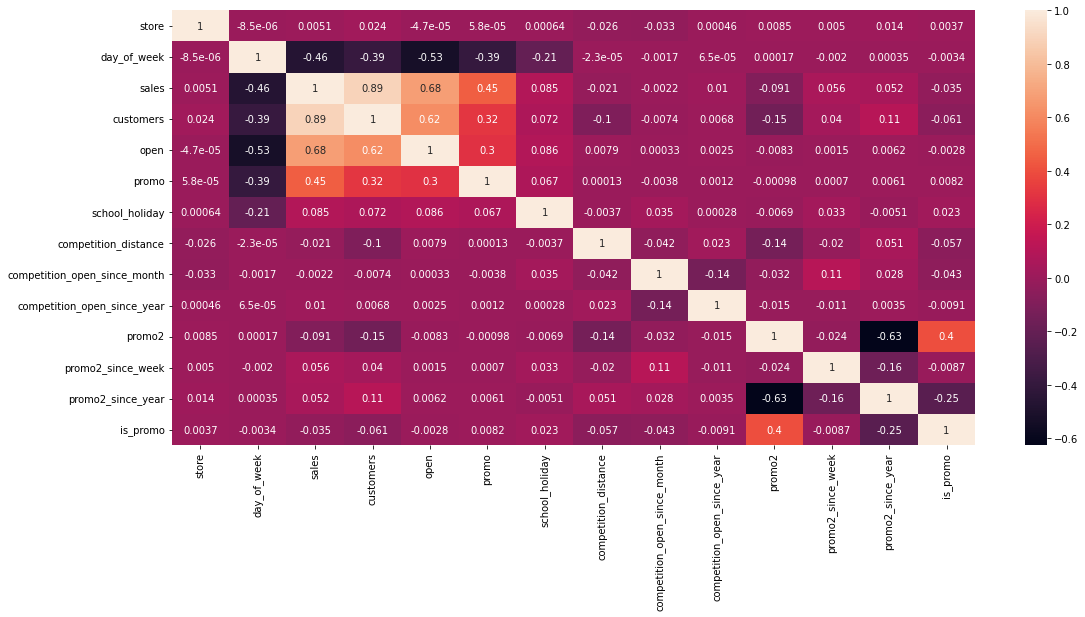

In [104]:
corralation = num_atributos.corr( method = 'pearson' )
plt.figure( figsize = ( 18,8 ) )
sns.heatmap( corralation, annot = True );

### 4.3.1. Atributos Categoricos

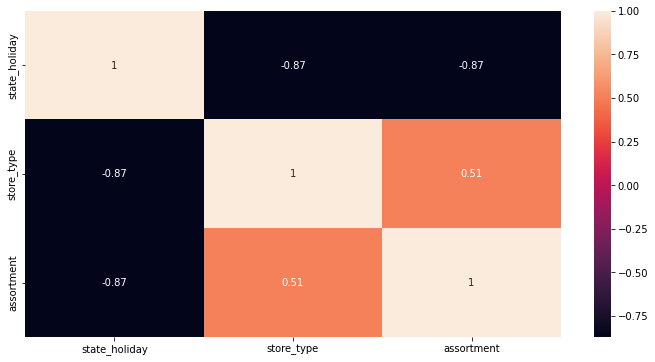

In [143]:
a = df4.select_dtypes( include= 'object' )

#calculo de cramer
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]} )

d = d.set_index( d.columns )

plt.figure( figsize= ( 12,6 ) )
sns.heatmap( d.corr(method = 'pearson'), annot = True );